## **Load and Preprocess the CIFAR-10 Dataset**

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Define a function to dynamically resize images during training and evaluation
def preprocess_images(images, labels):
    images = tf.image.resize(images, [224, 224])  # Resize to 224x224
    return images, labels

# Create TensorFlow datasets for efficient preprocessing
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess_images).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(preprocess_images).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess_images).batch(32).prefetch(tf.data.AUTOTUNE)

print(f"Training dataset: {x_train.shape}, {y_train.shape}")
print(f"Validation dataset: {x_val.shape}, {y_val.shape}")
print(f"Test dataset: {x_test.shape}, {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training dataset: (40000, 32, 32, 3), (40000, 10)
Validation dataset: (10000, 32, 32, 3), (10000, 10)
Test dataset: (10000, 32, 32, 3), (10000, 10)


## **Data Augmentation**

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import tensorflow as tf

# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),           # Randomly flip images horizontally
    RandomRotation(0.1),                # Randomly rotate images by ±10%
    RandomZoom(0.1)                     # Randomly zoom images by ±10%
])

# Apply augmentation to the training dataset
train_dataset_augmented = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Prefetch for efficiency
train_dataset_augmented = train_dataset_augmented.prefetch(tf.data.AUTOTUNE)

# Validation and test datasets remain unchanged
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

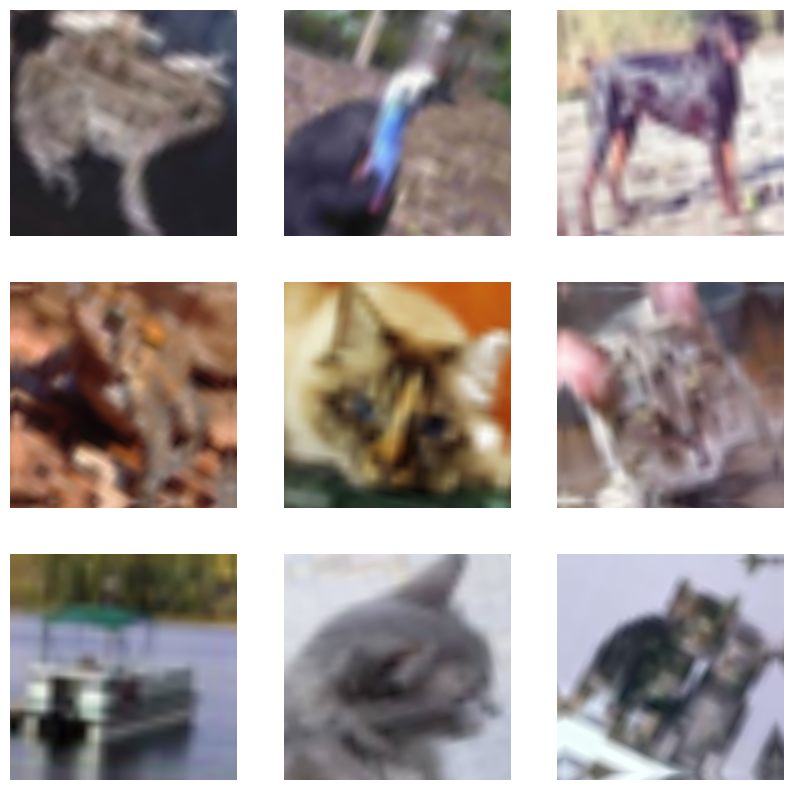

In [ ]:
import matplotlib.pyplot as plt

# Visualize a batch of augmented images
for images, labels in train_dataset_augmented.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()

## **Model implementation**

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Step 1: Load the pre-trained ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the base model layers
base_model.trainable = False

# Step 3: Build the custom model on top of the pre-trained base model
model = models.Sequential([
    layers.Resizing(224, 224),  # Resize the CIFAR-10 images to (224, 224)
    base_model,  # Add the pre-trained ResNet50 model
    layers.GlobalAveragePooling2D(),  # Global average pooling layer
    layers.Dense(512, activation='relu'),  # Fully connected layer
    layers.Dense(10, activation='softmax')  # Output layer for CIFAR-10 (10 classes)
])

# Step 4: Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Small learning rate for fine-tuning
    loss='categorical_crossentropy',  # Use categorical crossentropy for one-hot encoded labels
    metrics=['accuracy']  # Track accuracy during training
)

# Step 5: Train the model
history = model.fit(
    train_dataset_augmented,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=val_dataset
)

# Step 6: Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 559s 434ms/step - accuracy: 0.1131 - loss: 2.3143 - val_accuracy: 0.2174 - val_loss: 2.2535
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 545s 436ms/step - accuracy: 0.1535 - loss: 2.2607 - val_accuracy: 0.2410 - val_loss: 2.2066
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 543s 420ms/step - accuracy: 0.1812 - loss: 2.2206 - val_accuracy: 0.2578 - val_loss: 2.1633
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 537s 430ms/step - accuracy: 0.2008 - loss: 2.1827 - val_accuracy: 0.2694 - val_loss: 2.1223
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 580s 445ms/step - accuracy: 0.2157 - loss: 2.1461 - val_accuracy: 0.2698 - val_loss: 2.0800
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 527s 417ms/step - accuracy: 0.2311 - loss: 2.1101 - val_accuracy: 0.2781 - val_loss: 2.0426
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 571s 425ms/step - accuracy: 0.2440 - loss: 2.0776 - val_accuracy: 0.2853 - val_loss: 2.0101
Epoch 8/10


In [ ]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.3084 - loss: 1.9299
Validation Loss: 1.9410021305084229, Validation Accuracy: 0.3066999912261963


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.3595 - loss: 1.8149
Test Loss: 1.8185324668884277, Test Accuracy: 0.3529999852180481


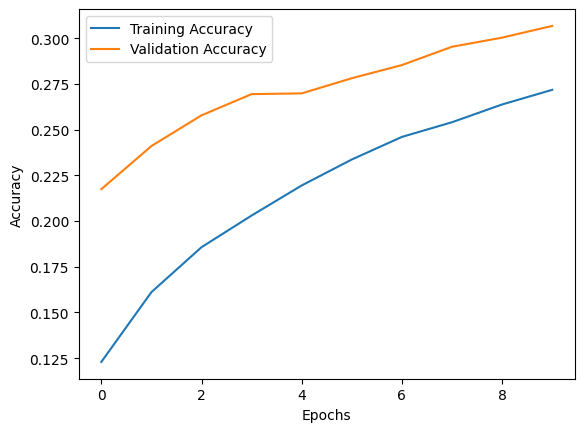

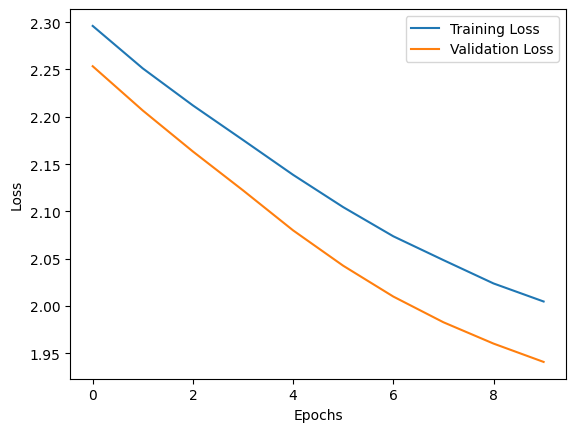

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save('my_model.keras')  # Save the model in Keras format

## **Hyperparameter Tuning**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Step 1: Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # Monitor validation loss
    factor=0.5,               # Reduce learning rate by a factor of 0.5
    patience=3,               # Wait for 3 epochs before reducing the learning rate
    min_lr=1e-6               # Set a minimum learning rate
)

# Step 2: Train the model with the learning rate scheduler
history = model.fit(
    train_dataset_augmented,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=val_dataset,
    callbacks=[lr_scheduler]  # Add the learning rate scheduler callback
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 515s 412ms/step - accuracy: 0.2757 - loss: 1.9889 - val_accuracy: 0.3110 - val_loss: 1.9232 - learning_rate: 1.0000e-04
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 560s 410ms/step - accuracy: 0.2808 - loss: 1.9720 - val_accuracy: 0.3210 - val_loss: 1.9058 - learning_rate: 1.0000e-04
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 571s 417ms/step - accuracy: 0.2889 - loss: 1.9578 - val_accuracy: 0.3221 - val_loss: 1.8955 - learning_rate: 1.0000e-04
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 556s 412ms/step - accuracy: 0.2936 - loss: 1.9475 - val_accuracy: 0.3278 - val_loss: 1.8816 - learning_rate: 1.0000e-04
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 579s 426ms/step - accuracy: 0.2959 - loss: 1.9348 - val_accuracy: 0.3364 - val_loss: 1.8653 - learning_rate: 1.0000e-04
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 544s 411ms/step - accuracy: 0.3028 - loss: 1.9216 - val_accuracy: 0.3336 - val_loss: 1.8606 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━

## **Fine-Tuning the Pretrained Model**

In [ ]:
# Step 1: Load the fine-tuned model
fine_tuned_model = tf.keras.models.load_model('my_model.keras')

# Step 2: Evaluate the model (on test dataset)
test_loss, test_accuracy = fine_tuned_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Step 3 (Optional): Continue training if needed
# You can unfreeze some layers or continue training with a lower learning rate
# For example, unfreeze the last few layers of ResNet50 for fine-tuning:
for layer in fine_tuned_model.layers[:143]:
    layer.trainable = False
for layer in fine_tuned_model.layers[143:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
fine_tuned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Continue training
history = fine_tuned_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5  # Continue for a few more epochs
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 149s 115ms/step - accuracy: 0.3436 - loss: 1.8173 - val_accuracy: 0.3469 - val_loss: 1.8191
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 114ms/step - accuracy: 0.3436 - loss: 1.8173 - val_accuracy: 0.3469 - val_loss: 1.8191
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 186s 101ms/step - accuracy: 0.3436 - loss: 1.8173 - val_accuracy: 0.3469 - val_loss: 1.8191
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.3436 - loss: 1.8173 - val_accuracy: 0.3469 - val_loss: 1.8191
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 159s 114ms/step - accuracy: 0.3436 - loss: 1.8173 - val_accuracy: 0.3469 - val_loss: 1.8191


In [ ]:
# Step 1: Unfreeze the last few layers of the ResNet50 base model
base_model.trainable = True  # Unfreeze the entire base model (adjust as needed)

for layer in base_model.layers[:-50]:  # Freeze all layers except the last 50
    layer.trainable = False

# Step 2: Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 3: Train the model again
history_finetune = model.fit(
    train_dataset_augmented,
    epochs=10,  # Additional epochs for fine-tuning
    validation_data=val_dataset,
    callbacks=[lr_scheduler]  # Keep the learning rate scheduler
)